In [1]:
import os
import pickle
import warnings
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
collections = "synthetic_all_rsi"  # top_bb / top_rsi / top

top_logs = os.listdir(f"../trade_log/{collections}")

log_returns = {
    "strat_name": [],
    "return": []
}

for log in top_logs:
    if not log.endswith(".pkl"):
        continue

    with open(f"../trade_log/{collections}/{log}", "rb") as f:
        log_returns['strat_name'].append(log)
        data = pickle.load(f)
        log_returns['return'].append(np.array(data['return']).cumsum())

In [3]:
df = pd.DataFrame(log_returns['return']).T

In [4]:
act_weights = sorted(os.listdir(f"../{collections}_act_weights"))

weights = []

for weight in act_weights:
    if weight.split(".")[0].split("_")[-1] == '1':
        mat = np.load(f"../{collections}_act_weights/" + weight)
        weights.append(mat)

In [5]:
state = pd.read_csv("../env_data/sp500.csv")
state["year"] = state["Date"].apply(lambda x: int(x.split("-")[0]))
year_counts = state["year"].value_counts().sort_index().values[1:]

In [6]:
def calculate_ret(mat: np.ndarray, s: pd.DataFrame) -> List[float]:
    prev_act, have_position, trade_return = None, False, []
    for idx, act in enumerate(mat):
        a = np.argmax(act)

        if have_position is False:
            if a == 0:
                have_position = True
                trade_return.append(s['return'].iloc[idx])

            elif a == 3:
                have_position = True
                trade_return.append(-1 * s['return'].iloc[idx])

            else:
                trade_return.append(0)

            prev_act = a

        elif have_position is True:
            if prev_act == 0:
                if a == 2:
                    have_position = True
                    prev_act = 0
                    trade_return.append(s['return'].iloc[idx])

                elif a in [0, 1, 3]:
                    have_position = False
                    trade_return.append(s['return'].iloc[idx])

            elif prev_act == 3:
                if a == 1:
                    have_position = True
                    prev_act = a
                    trade_return.append(-1 * s['return'].iloc[idx])

                elif a in [0, 2, 3]:
                    have_position = False
                    prev_act = a
                    trade_return.append(-1 * s['return'].iloc[idx])

            else:
                trade_return.append(0)

    return trade_return

In [7]:
year_list = sorted(state["year"].unique())[1:]

total_ret = []

for i, m in enumerate(weights):
    m = m[:year_counts[i], :]
    binary_m = np.where(m > 0.5, 1, 0)
    s = state[state['year'] == year_list[i]]
    s['return'] = s['Close'].pct_change().fillna(0)
    total_ret += calculate_ret(binary_m, s)

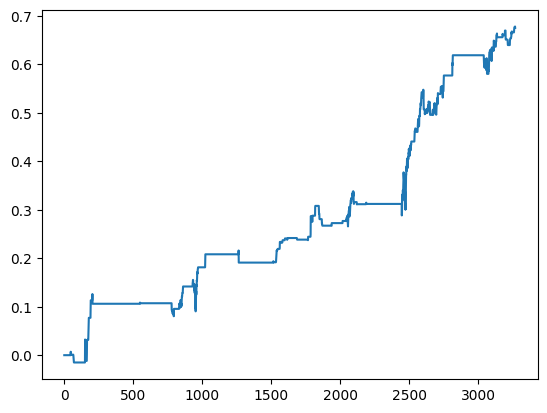

In [8]:
plt.plot(np.array(total_ret).cumsum())

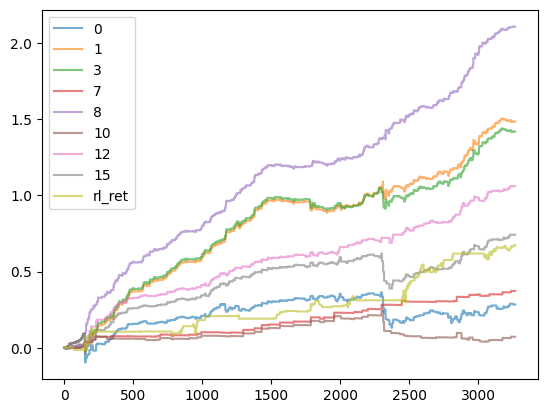

In [19]:
df_new = df.iloc[:len(total_ret), :]
df_new['rl_ret'] = np.array(total_ret).cumsum()

positive_cols = df_new.iloc[-1] > 0
filtered_df = df_new.loc[:, positive_cols]

plt.plot(filtered_df, label=filtered_df.columns, alpha=0.6)
plt.legend()

In [20]:
print(f"Cumulative return: \n{filtered_df.iloc[-1, :]}")

Cumulative return: 
0         0.283487
1         1.485674
3         1.420294
7         0.372825
8         2.108617
10        0.072644
12        1.061082
15        0.742206
rl_ret    0.675392
Name: 3269, dtype: float64
